## import libs

In [343]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import join, isfile

## data management

### locations

In [344]:
folder = './data'
data_loc = 'measurements.pkl'

## data storage class

In [345]:
class DataCube:
    def __init__(self, shape):
        if len(shape) != 3:
            raise Exception('shape should be of length 3, not {}'.format(len(shape)))
        self.data = np.zeros(
            shape=tuple(int(np.ceil(s[1]['max']-s[1]['min']) / s[1]['inc']) for s in shape)
        )
        
        self.shape = { i:{'name': shape[i][0][0],
                          'type': shape[i][0][1],
                          'min': shape[i][1]['min'],
                          'max': shape[i][1]['max'], 
                          'inc': shape[i][1]['inc']
                     } for i in range(len(shape)) }
        
        self.imap = { shape[i][0][0]: i for i in range(len(shape))}
    
    def sets(self, setpoints, value):
        if len(setpoints) != 3:
            raise Exception('shape should be of length 3, not {}'.format(len(shape)))
        o = [0]*3
        for setpoint in setpoints:
            col = self.imap[setpoint[0]]
            if setpoint[1] < self.shape[col]['min'] or setpoint[1] > self.shape[col]['max']:
                raise Exception('setpoint "{}" with value {} is out of range [{}, {}]'
                                .format(setpoint[0], setpoint[1], self.shape[col]['min'], self.shape[col]['max'])
                )
            o[col] = int((setpoint[1]-self.shape[col]['min']) / self.shape[col]['inc'])
        self.data[o[0]][o[1]][o[2]] = value
    
    def gets(self, setpoints):
        if len(setpoints) != 3:
            raise Exception('shape should be of length 3, not {}'.format(len(shape)))
        o = [0]*3
        for setpoint in setpoints:
            col = self.imap[setpoint[0]]
            if setpoint[1] < self.shape[col]['min'] or setpoint[1] > self.shape[col]['max']:
                raise Exception('setpoint "{}" with value {} is out of range [{}, {}]'
                                .format(setpoint[0], setpoint[1], self.shape[col]['min'], self.shape[col]['max'])
                )
            o[col] = int((setpoint[1]-self.shape[col]['min']) / self.shape[col]['inc'])
        return self.data[o[0]][o[1]][o[2]]

### frames

Data Shape

+ ramp dist: 5 - 15 by 1
+ drive: 40 - 100 by 3
+ voltage: 7.7 to 8.4 by .01
+ jump dist: 10 to 180

In [346]:
shape = [
    (('ramp_dist', np.float64), { 'min': 5, 'max': 15, 'inc': 1 }),
    (('drive', int), { 'min': 40, 'max': 100, 'inc': 3 }),
    (('voltage', int), { 'min': 7.7, 'max': 8.5, 'inc': 0.01 }),
]

In [347]:
data = None
if isfile(join(folder, data_loc)):
    print('loading data...')
    with open(join(folder, data_loc), 'rb') as file:
        data = pickle.load(file)
    print('data is loaded.')
else:
    print('creating data file...')
    data = DataTesseract(shape)
    with open(join(folder, data_loc), 'wb') as file:
        pickle.dump(data, file)
    print('data file has been created.')

loading data...
data is loaded.


# Example of how to plot 

In [348]:
# Create a test DataCube
test = DataCube([
    (('dist', int), { 'min': 5, 'max': 15, 'inc': 1 }),
    (('drive', int), { 'min': 40, 'max': 100, 'inc': 3 }),
    (('voltage', int), { 'min': 7.7, 'max': 8.5, 'inc': 0.01 }),
])

In [349]:
# Fill the values for dist and drive with some constant voltage
for i in range(40, 100):
    for j in range(5, 15):
        test.sets([('dist', j), ('drive', i), ('voltage', 8.5)], (i**2 - j**3 + (i*j)**3) * 5)

for i in range(40, 100):
    for j in range(5, 15):
        test.sets([('dist', j), ('drive', i), ('voltage', 8.1)], (i**1.9 - j**3.2 + (i*j)**3.2) * 5)

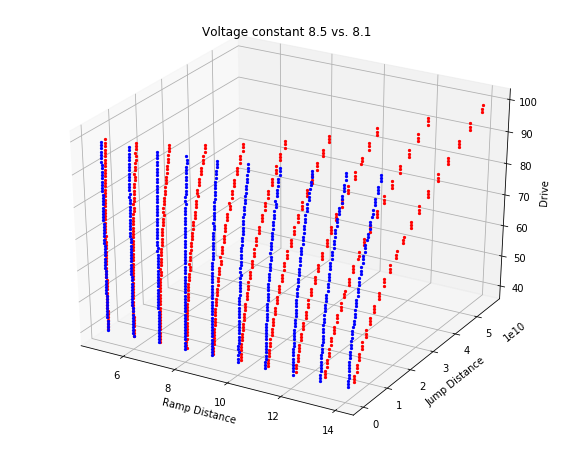

In [350]:
# plot the values at those set above
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for v in [(8.5, 'b'), (8.1, 'r')]:
    for i in range(40, 100):
        for j in range(5, 15):
            xs = j
            ys = test.gets([('dist', j), ('drive', i), ('voltage', v[0])])
            zs = i
            ax.scatter(xs, ys, zs, c=v[1], marker='.')

ax.set_xlabel('Ramp Distance')
ax.set_ylabel('Jump Distance')
ax.set_zlabel('Drive')
plt.title('Voltage constant 8.5 vs. 8.1')
plt.show()